In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from astropy.io import ascii

### Load ICME LIST

In [2]:
icme_list = pd.read_excel("Original_Full_Richardson_cane_list(2010-2023).xlsx")
icme_list['Start_time'] = pd.to_datetime(icme_list['Start_time'].str.split(' ').str[0], format='%Y/%m/%d')
icme_list['End_time'] = pd.to_datetime(icme_list['End_time'].str.split(' ').str[0], format='%Y/%m/%d')
icme_list.head()

,Start_time,End_time
0,2010-01-01,2010-01-03
1,2010-02-07,2010-02-08
2,2010-02-11,2010-02-12
3,2010-02-19,2010-02-20
4,2010-02-21,2010-02-22


In [3]:
start_time_list = list(icme_list['Start_time'])
end_time_list = list(icme_list['End_time'])
whole_list = []
for i in range(len(start_time_list)):
    new_list = pd.date_range(start_time_list [i], end_time_list[i],) #freq='h'
    whole_list.append(new_list)
combined_list = [date for sublist in whole_list for date in sublist]

### LOAD THE OMINWEB DATA

` Listing for omni2_daily data from 20100101 to 20231231`
`Selected parameters:`
 * `Scalar BnT`
 * `SW Plasma Temperature, K`
 * `SW Proton Density, N/cm^3`
 * `SW Plasma Speed, km/s`

In [4]:
Ommidata = ascii.read("omnidataset.txt",
                      names =["Year","DOY", "HR", "B(nT)", "T(k)", "n(cm^-3)", "V(Km/s)" ]  )


In [5]:
ascii.write(Ommidata, "Omniwind_csv.csv", format='csv', overwrite=True)  

In [6]:
Solar_wind = pd.read_csv("Omniwind_csv.csv")

In [7]:
(Solar_wind== 999.9).sum()

Year         0
DOY          0
HR           0
B(nT)       40
T(k)         0
n(cm^-3)     3
V(Km/s)      0
dtype: int64

In [8]:
Solar_wind["T(10^3 k)"] = Solar_wind['T(k)']/1000
# SWEPAM['Ind_DOY'] = range(1, len(SWEPAM) + 1)
Solar_wind["Combined"] = Solar_wind["Year"]*1000 + Solar_wind["DOY"] 
Solar_wind["DATE"] = pd.to_datetime(Solar_wind["Combined"], format = "%Y%j")
Solar_wind["N(cm^3)"] = Solar_wind['n(cm^-3)']
Solar_wind= Solar_wind[['DATE','B(nT)','T(10^3 k)', 'N(cm^3)', 'V(Km/s)']]
Solar_wind.head()

,DATE,B(nT),T(10^3 k),N(cm^3),V(Km/s)
0,2010-01-01,3.8,25.962,6.0,288.0
1,2010-01-02,6.8,19.363,7.9,290.0
2,2010-01-03,5.9,44.011,11.2,286.0
3,2010-01-04,5.8,59.164,7.6,288.0
4,2010-01-05,4.3,27.738,6.3,293.0


In [9]:
Solar_wind_filtered = Solar_wind[~Solar_wind['DATE'].isin(combined_list)]

In [10]:
solar_wind_filtered_mask = (Solar_wind_filtered["DATE"] >= "2010-05-13") & (Solar_wind_filtered["DATE"] <= "2023-12-31") 
Solar_wind_filtered = Solar_wind_filtered.loc[solar_wind_filtered_mask]
Solar_wind_filtered.head()

,DATE,B(nT),T(10^3 k),N(cm^3),V(Km/s)
132,2010-05-13,3.5,85.935,4.0,420.0
133,2010-05-14,4.5,104.089,2.9,361.0
134,2010-05-15,4.1,35.633,2.0,364.0
135,2010-05-16,3.3,52.059,4.2,332.0
136,2010-05-17,4.7,87.494,8.7,357.0


In [11]:
Omni_velocity = Solar_wind_filtered.drop(columns=(['B(nT)','T(10^3 k)', 'N(cm^3)']), axis=0)

In [12]:
Omni_velocity.dropna(inplace=True)

In [13]:
Omni_velocity.to_csv("Omni_velocity.csv", index=False, columns=None)

### Loading Hourly OMNIWEB SW DATA 

`TEXT File`

In [14]:
omni = ascii.read("Hourly_data_OMNIWEB_data.txt",
                      names =["Year","DOY", "HR", "V(Km/s)"] )
 

In [15]:
ascii.write(omni, 'Hourly_data_OMNIWEB_data.csv', format='csv', overwrite=True)  

In [16]:
hourly_data = pd.read_csv('Hourly_data_OMNIWEB_data.csv')
hourly_data["Combined"] = hourly_data["Year"]*1000 + hourly_data["DOY"] 
hourly_data["DATE"] = pd.to_datetime(hourly_data["Combined"], format = "%Y%j")
# Add Hour to datetime
hourly_data["DATE"] += pd.to_timedelta(hourly_data['HR'], unit='h')
hourly_data.head()

,Year,DOY,HR,V(Km/s),Combined,DATE
0,2010,1,0,283.0,2010001,2010-01-01 00:00:00
1,2010,1,1,280.0,2010001,2010-01-01 01:00:00
2,2010,1,2,280.0,2010001,2010-01-01 02:00:00
3,2010,1,3,281.0,2010001,2010-01-01 03:00:00
4,2010,1,4,282.0,2010001,2010-01-01 04:00:00


In [17]:
hourly_data= hourly_data[['DATE','V(Km/s)']]
hourly_data.set_index('DATE', inplace=True)

### REMOVED MISSING DATAS/ NAN VALUE (9999)

In [18]:
(hourly_data== 9999).sum()

V(Km/s)    456
dtype: int64

In [19]:
hourly_data = hourly_data[hourly_data['V(Km/s)'] != 9999]

In [20]:
(hourly_data== 9999).sum()

V(Km/s)    0
dtype: int64

### oBTAINED THE STANDARD DEVIATION BEFORE REMOVING ICME EVENTS

In [21]:
daily_deviation = hourly_data['V(Km/s)'].resample('D').std().reset_index()

In [22]:
daily_deviation.to_csv("ICME_included_standard_deviation_Velocity.csv", index=False, columns=None)

### removed  icme events and save the standard deviation

In [23]:
daily_deviation_filtered = daily_deviation[~daily_deviation["DATE"].isin(combined_list)]

In [24]:
daily_deviation_filtered_mask = (daily_deviation_filtered["DATE"] >= "2010-05-13") & (daily_deviation_filtered["DATE"] <= "2023-12-31") 
daily_deviation_filtered = daily_deviation_filtered.loc[daily_deviation_filtered_mask]


In [25]:
daily_deviation_filtered.to_csv("standard_deviation_Velocity.csv", index=False, columns=None)

### LOAD THE ALREADY FILTERED sOLAR WIND DATA

In [26]:
Solar_wind_daily = pd.read_csv("Omni_velocity.csv")
Solar_wind_daily.head(10)

,DATE,V(Km/s)
0,2010-05-13,420.0
1,2010-05-14,361.0
2,2010-05-15,364.0
3,2010-05-16,332.0
4,2010-05-17,357.0
5,2010-05-18,355.0
6,2010-05-19,410.0
7,2010-05-20,472.0
8,2010-05-21,443.0
9,2010-05-22,391.0


In [27]:
np.min(Solar_wind_daily["V(Km/s)"])

259.0

In [28]:
bool_series = Solar_wind_daily["V(Km/s)"] >= 500
count_true = bool_series.value_counts().get(True, 0)

print(count_true)  
# (Solar_wind_daily["V(Km/s)"] >= 500).sum()

776


In [29]:
np.max(Solar_wind_daily["V(Km/s)"])

753.0

In [30]:
np.mean(Solar_wind_daily["V(Km/s)"])

415.1

In [31]:
# np.min(Solar_wind_daily["V(Km/s)"])
np.bincount(Solar_wind_daily["V(Km/s)"]).argmax()
# .argmax()

364

In [32]:
np.std(Solar_wind_daily["V(Km/s)"])

88.10379121585824

In [33]:
np.sqrt(len(Solar_wind_daily))

67.15653356152326

In [34]:
np.sqrt(4510)

67.15653356152326

In [35]:
### We segmented the dataset into 67 bins, which depicts the square root of the total number of the dataset. and we observed that the distribution was skewed to the left

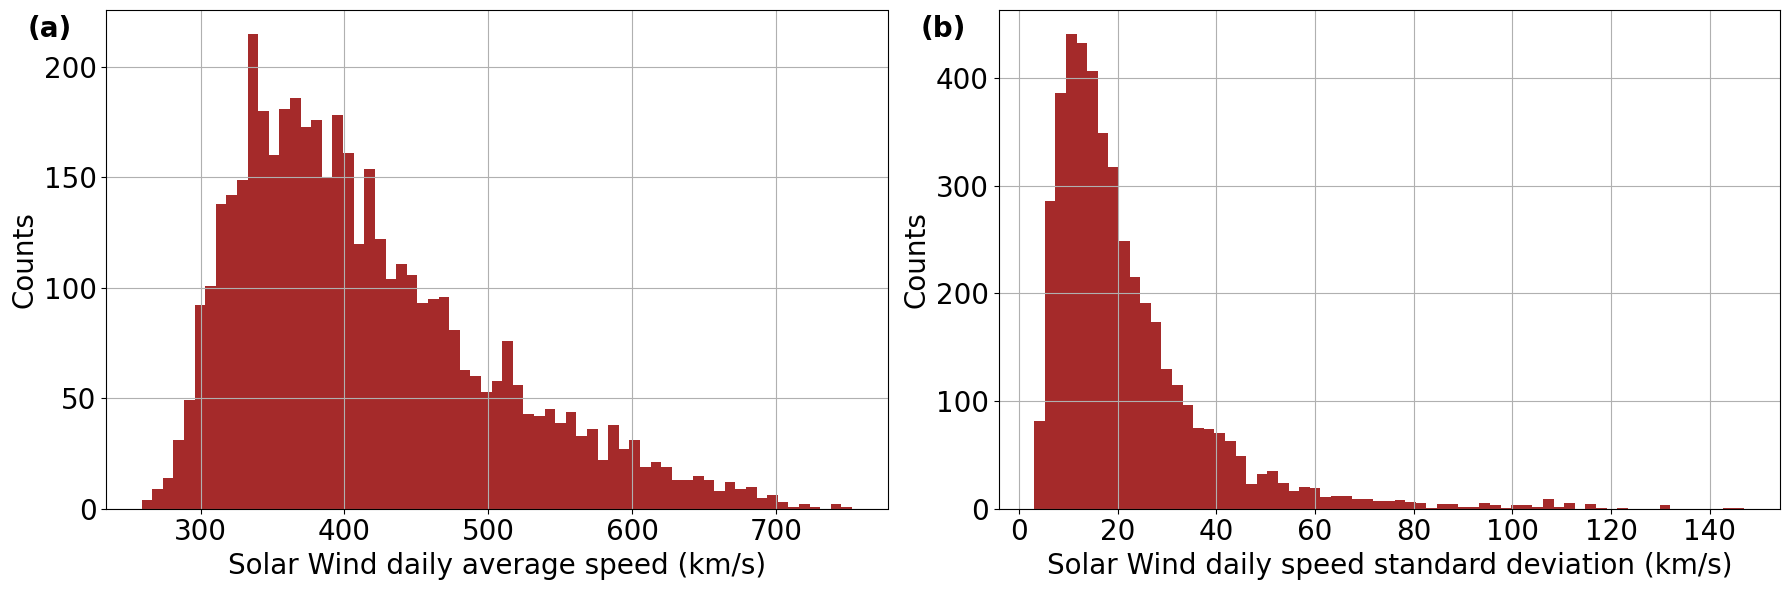

In [36]:
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
solar_wind_histogram=plt.hist(Solar_wind_daily["V(Km/s)"], bins= 67, color='brown')#int(np.sqrt(len(Solar_wind_daily))),color='brown')
plt.ylabel('Counts',fontsize=20)
plt.xlabel('Solar Wind daily average speed (km/s)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid("on")
plt.text(-0.1, 0.99, '(a)', transform=plt.gca().transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
# plt.title('Distribution of Solar Wind speed over all years',fontsize=20)


plt.subplot(1,2,2)
solar_standard_devaition_histogram=plt.hist(daily_deviation_filtered["V(Km/s)"],bins= 67,color='brown') #,int(np.sqrt(len(Solar_wind_daily))), color='brown')
plt.ylabel('Counts',fontsize=20)
plt.xlabel('Solar Wind daily speed standard deviation (km/s)', fontsize=20)
plt.text(-0.1, 0.99, '(b)', transform=plt.gca().transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.title('Distribution of Solar Wind speed $\sigma$ over all years',fontsize=20)
plt.tight_layout()
plt.grid("on")
plt.savefig("Solar_wind_hist_plot.png")
